# Introduction
New York City is a large and ethnically diverse metropolis. With it's diverse culture , comes diverse food portfolios. There are a lot of restaurants in New York City. So as part of this project , we will list and visualize all major parts of New York City that has great Chinese restaurant. 

# Data
1. New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
2. Chinese restaurants in each neighborhood of new york city from Foursquare including position, rate, etc.
3. GeoSpace data

# Questions
1. What are best location in New York City for Chinese restaurant?

2. What is the best Chinese restaurant in New York?

3. Which all areas lack Chinese restaurants?

4. Which is the best place to stay if you prefer Chinese cuisine?

# Methodology
1. Collecting the New York city data from "https://cocl.us/new_york_dataset".
2. We will find then filter out all Chinese Restuarant venues with FourSquare API
3. Retriveing the Ratings, Tips, and Like count for all the Chinese Resturants.
4. Visualizing the Ranking of neighborhoods using python's Folium library.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import seaborn as sns
from bs4 import BeautifulSoup
#!pip install geocoder
import geocoder
import os
#!pip install folium
import folium 
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


# Define Functions

In [2]:
def geo_location(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'BK0VIXTHSDSVOTIMU1O0KYOSLWTECQFDVKX4JUSW4CQB5BCD' # your Foursquare ID
    CLIENT_SECRET = '3B52DX4Y5B1AEUZZW13PXQ1WS14WRDJHFTFUJSLH4FCOUABB' # your Foursquare Secret
    VERSION = '20200401' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'BK0VIXTHSDSVOTIMU1O0KYOSLWTECQFDVKX4JUSW4CQB5BCD' # your Foursquare ID
    CLIENT_SECRET = '3B52DX4Y5B1AEUZZW13PXQ1WS14WRDJHFTFUJSLH4FCOUABB' # your Foursquare Secret
    VERSION = '20200401' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    #print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [6]:
NY_data =get_new_york_data()

In [7]:
NY_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
NY_data.shape

(306, 4)

In [9]:
NY_data.groupby(['Borough'],as_index = False)['Neighborhood'].count()

,Borough,Neighborhood
0,Bronx,52
1,Brooklyn,70
2,Manhattan,40
3,Queens,81
4,Staten Island,63


<AxesSubplot:xlabel='Borough', ylabel='Neighborhood'>

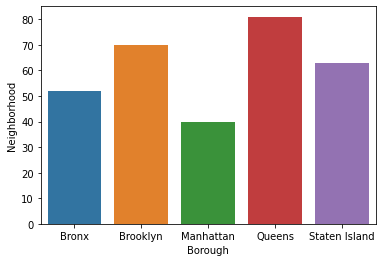

In [10]:
sns.barplot(x = 'Borough',y='Neighborhood', data = NY_data.groupby(['Borough'],as_index = False)['Neighborhood'].count())

In [11]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in NY_data.values.tolist():
    try:
        Borough, Neighborhood, Latitude, Longitude=row
        venues = get_venues(Latitude,Longitude)
        chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
        print('(',count,'/',len(NY_data),')','Chinese Resturants in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
    except KeyError:
            pass     
    for resturant_detail in chinese_resturants.values.tolist():
        try:
            id, name , category=resturant_detail
            chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
        except KeyError:
            pass     
    count+=1

( 1 / 306 ) Chinese Resturants in Wakefield, Bronx:1
( 2 / 306 ) Chinese Resturants in Co-op City, Bronx:1
( 3 / 306 ) Chinese Resturants in Eastchester, Bronx:1
( 4 / 306 ) Chinese Resturants in Fieldston, Bronx:1
( 5 / 306 ) Chinese Resturants in Riverdale, Bronx:0
( 6 / 306 ) Chinese Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Chinese Resturants in Marble Hill, Manhattan:1
( 8 / 306 ) Chinese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Chinese Resturants in Norwood, Bronx:3
( 10 / 306 ) Chinese Resturants in Williamsbridge, Bronx:1
( 11 / 306 ) Chinese Resturants in Baychester, Bronx:2
( 12 / 306 ) Chinese Resturants in Pelham Parkway, Bronx:3
( 13 / 306 ) Chinese Resturants in City Island, Bronx:1
( 14 / 306 ) Chinese Resturants in Bedford Park, Bronx:2
( 15 / 306 ) Chinese Resturants in University Heights, Bronx:1
( 16 / 306 ) Chinese Resturants in Morris Heights, Bronx:2
( 17 / 306 ) Chinese Resturants in Fordham, Bronx:1
( 18 / 306 ) Chinese Resturants in East Tremont, Bronx:

( 141 / 306 ) Chinese Resturants in Sunnyside, Queens:4
( 142 / 306 ) Chinese Resturants in East Elmhurst, Queens:1
( 143 / 306 ) Chinese Resturants in Maspeth, Queens:2
( 144 / 306 ) Chinese Resturants in Ridgewood, Queens:2
( 145 / 306 ) Chinese Resturants in Glendale, Queens:1
( 146 / 306 ) Chinese Resturants in Rego Park, Queens:5
( 147 / 306 ) Chinese Resturants in Woodhaven, Queens:3
( 148 / 306 ) Chinese Resturants in Ozone Park, Queens:1
( 149 / 306 ) Chinese Resturants in South Ozone Park, Queens:1
( 150 / 306 ) Chinese Resturants in College Point, Queens:2
( 151 / 306 ) Chinese Resturants in Whitestone, Queens:1
( 152 / 306 ) Chinese Resturants in Bayside, Queens:2
( 153 / 306 ) Chinese Resturants in Auburndale, Queens:2
( 154 / 306 ) Chinese Resturants in Little Neck, Queens:5
( 155 / 306 ) Chinese Resturants in Douglaston, Queens:4
( 156 / 306 ) Chinese Resturants in Glen Oaks, Queens:0
( 157 / 306 ) Chinese Resturants in Bellerose, Queens:1
( 158 / 306 ) Chinese Resturants

( 276 / 306 ) Chinese Resturants in Stuyvesant Town, Manhattan:0
( 277 / 306 ) Chinese Resturants in Flatiron, Manhattan:2
( 278 / 306 ) Chinese Resturants in Sunnyside Gardens, Queens:1
( 279 / 306 ) Chinese Resturants in Blissville, Queens:4
( 280 / 306 ) Chinese Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Chinese Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Chinese Resturants in Weeksville, Brooklyn:5
( 283 / 306 ) Chinese Resturants in Broadway Junction, Brooklyn:2
( 284 / 306 ) Chinese Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Chinese Resturants in Manor Heights, Staten Island:3
( 286 / 306 ) Chinese Resturants in Willowbrook, Staten Island:2
( 287 / 306 ) Chinese Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Chinese Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Chinese Resturants in Roxbury, Queens:0
( 290 / 306 ) Chinese Resturants in Homecrest, Brooklyn:2
( 291 / 306 ) Chinese Resturants in Middle Village, Queens:3
( 292 / 306 ) Chine

In [12]:
chinese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4edbac4e775bcc53fc0ed5f8,Hong Kong China King
1,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet
2,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant
3,Bronx,Fieldston,4cc4d337be40a35d390b814c,Lee's Chinese Kitchen
4,Manhattan,Marble Hill,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant


In [14]:
chinese_rest_ny.to_excel('D:/Python/chinese_rest_ny.xlsx',index = False)

In [11]:
chinese_rest_ny = pd.read_excel('D:/Python/chinese_rest_ny.xlsx')

In [12]:
chinese_rest_ny.shape

(414, 4)

In [13]:
chinese_rest_ny.groupby(['Borough'],as_index = False)['Name'].count()

,Borough,Name
0,Bronx,65
1,Brooklyn,103
2,Manhattan,46
3,Queens,151
4,Staten Island,49


In [14]:
chinese_rest_ny.groupby(['Neighborhood'],as_index = False)['Name'].count().sort_values(by = 'Name',ascending = False)[:10]

,Neighborhood,Name
70,Flushing,13
151,Queensboro Hill,8
75,Fresh Meadows,6
183,Utopia,5
187,Weeksville,5
156,Rego Park,5
176,Sunnyside,5
105,Little Neck,5
3,Bath Beach,5
64,Far Rockaway,5


In [ ]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4edbac4e775bcc53fc0ed5f8
( 1 / 414 ) processed
                         ID            Name  Likes  Rating  Tips
0  4c66dcfaaebea593955a74d0  Chinese Buffet      7     5.0    10
( 2 / 414 ) processed
                         ID                          Name  Likes  Rating  Tips
0  4dabc3dc93a04642f09ccabd  Xing Lung Chinese Restaurant      6     6.7     0
( 3 / 414 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4cc4d337be40a35d390b814c
( 4 / 414 ) processed
                         ID                           Name  Likes  Rating  \
0  4d965fd061a3a1cde4989a42  Lucky Star Chinese Restaurant      3     7.8   

   Tips  
0     5  
( 5 / 414 ) processed
                         ID                          Name  Likes  Rating  Tips
0  4e4d0387bd413c4cc66dfd72  Hung Hing Chinese Restaurant      5     6.3     2
( 6 / 414 ) processed
           

                         ID        Name  Likes  Rating  Tips
0  4a5beec3f964a52006bc1fe3  86 Noodles     19     7.2    22
( 55 / 414 ) processed
                         ID           Name  Likes  Rating  Tips
0  4b512cbaf964a520f64527e3  ha ha chinese      4     8.0     4
( 56 / 414 ) processed
                         ID            Name  Likes  Rating  Tips
0  574a1a53498e6a1b7cb336cb  Orchid Dynasty      6     7.7     1
( 57 / 414 ) processed
                         ID         Name  Likes  Rating  Tips
0  4c65da95f7a80f47b6959c7a  Spicy Bampa     28     7.4    10
( 58 / 414 ) processed
                         ID       Name  Likes  Rating  Tips
0  4bdcc1043904a593ba9e4f9e  New Ruans      9     7.5     2
( 59 / 414 ) processed
                         ID                 Name  Likes  Rating  Tips
0  54f6521c498eb03ddc080d18  Han Wong Restaurant      5     6.9     2
( 60 / 414 ) processed
                         ID                    Name  Likes  Rating  Tips
0  51d868ac498ef583276dcf

                         ID     Name  Likes  Rating  Tips
0  4a71ff01f964a52016da1fe3  Kum Kau    109     7.8    77
( 109 / 414 ) processed
                         ID             Name  Likes  Rating  Tips
0  4bedc857e24d20a17afc7114  Oriental Palace      4     6.6     5
( 110 / 414 ) processed
                         ID         Name  Likes  Rating  Tips
0  59da9590e1f0aa52976b8f35  Han Dynasty    164     8.7    32
( 111 / 414 ) processed
                         ID                Name  Likes  Rating  Tips
0  5db3649a8d15ba00089b4e9b  Xi'an Famous Foods     10     8.8     3
( 112 / 414 ) processed
                         ID         Name  Likes  Rating  Tips
0  59da9590e1f0aa52976b8f35  Han Dynasty    164     8.7    32
( 113 / 414 ) processed
                         ID                           Name  Likes  Rating  \
0  4bfafc771134b713e48c0fc9  Green Lake Chinese Restaurant      5     7.9   

   Tips  
0     5  
( 114 / 414 ) processed
                         ID                    

                         ID     Name  Likes  Rating  Tips
0  59ac42570868a23a1e0fde8f  Red Hot     10     8.1     1
( 162 / 414 ) processed
                         ID           Name  Likes  Rating  Tips
0  5ba99889f05ca8003a126617  Atlas Kitchen     10     7.9     3
( 163 / 414 ) processed
                         ID           Name  Likes  Rating  Tips
0  5ba99889f05ca8003a126617  Atlas Kitchen     10     7.9     3
( 164 / 414 ) processed
                         ID       Name  Likes  Rating  Tips
0  5b4a97c16adbf5002ce288c2  Dun Huang     10     7.7     2
( 165 / 414 ) processed
                         ID     Name  Likes  Rating  Tips
0  59ac42570868a23a1e0fde8f  Red Hot     10     8.1     1
( 166 / 414 ) processed
                         ID                     Name  Likes  Rating  Tips
0  58fbdc8fe0755067a6dcf3ee  108 Food- Dried Hot Pot     39     7.7    12
( 167 / 414 ) processed
                         ID  Name  Likes  Rating  Tips
0  5f8f4321094d0d6876179d8c  Milu      8     

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c5de5a285a1e21e32db5a11
( 214 / 414 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4ccf49fe1ac7a1cd71c91292
( 215 / 414 ) processed
                         ID           Name  Likes  Rating  Tips
0  4d8805b7d85f370481b0c9db  Little Pepper     73     8.2    38
( 216 / 414 ) processed
                         ID                       Name  Likes  Rating  Tips
0  4bffe248ca1920a1206ced81  Keilly Chinese Restaurant      6     7.1     8
( 217 / 414 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4bb674486edc76b0ecf8301c
( 218 / 414 ) processed
                         ID         Name  Likes  Rating  Tips
0  4b78929ff964a520aad72ee3  Bell Garden      1     7.2     6
( 219 / 414 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4ce842849f776ea8190b5d2

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4f3246d319836c91c7c7bf46
( 269 / 414 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e4e41cdbd4101d0d7a61ddb
( 270 / 414 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4cb337c21463a143efe7b2a9
( 271 / 414 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4b8601a1f964a5203f7d31e3
( 272 / 414 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e4e3e1fbd4101d0d7a5c27a
( 273 / 414 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c20ec904889a5932f262720
( 274 / 414 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e4dfb24bd4101d0d79f8cf5
( 275 / 414 ) processed
      

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4ec82b386da1d1092f724459
( 322 / 414 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c5a155e04f9be9a8f14f160
( 323 / 414 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e5181baa80997aa8a56666f
( 324 / 414 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4bd4c5564e32d13ab2e0bf80
( 325 / 414 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4bd4c5564e32d13ab2e0bf80
( 326 / 414 ) processed
                         ID     Name  Likes  Rating  Tips
0  4bba73677421a593ebd4c340  Jac Mao     23     7.6    12
( 327 / 414 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4cc61c46b2beb1f74faa264c
( 328 / 414 ) processed
        

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4d0fddf97177b1f739e44d22
( 378 / 414 ) processed
                         ID    Name  Likes  Rating  Tips
0  4daa263f0cb6a89c62682125  Hardee     16     8.2     6
( 379 / 414 ) processed
                         ID          Name  Likes  Rating  Tips
0  4c9c2ba40e9bb1f706add15f  Leon Kitchen      5     6.5     4
( 380 / 414 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4fc54882e4b0d67823964965
( 381 / 414 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4bf1e92d189f0f470edbb762
( 382 / 414 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4d59e41535966dcbcd775a28
( 383 / 414 ) processed
                         ID                              Name  Likes  Rating  \
0  4d8151697c956dcb09cff27b  New Jin Shing Chinese Restuarant   

In [21]:
chinese_rest_stats_ny_v2 = chinese_rest_stats_ny.loc[chinese_rest_stats_ny['Name']!=0]

In [22]:
chinese_rest_stats_ny_v2.to_excel('chinese_rest_stats_ny_v2.xlsx',index = False)

In [15]:
chinese_rest_stats_ny_excel = pd.read_excel('D:/Python/chinese_rest_stats_ny_v2.xlsx')

In [16]:
chinese_rest_stats_ny_excel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       253 non-null    object 
 1   Neighborhood  253 non-null    object 
 2   ID            253 non-null    object 
 3   Name          253 non-null    object 
 4   Likes         253 non-null    int64  
 5   Rating        253 non-null    float64
 6   Tips          253 non-null    int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 14.0+ KB


In [17]:
chinese_rest_stats_ny_excel['Likes'] = chinese_rest_stats_ny_excel['Likes'].astype('int')
chinese_rest_stats_ny_excel['Tips'] = chinese_rest_stats_ny_excel['Tips'].astype('int')

In [18]:
chinese_rest_stats_ny_excel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       253 non-null    object 
 1   Neighborhood  253 non-null    object 
 2   ID            253 non-null    object 
 3   Name          253 non-null    object 
 4   Likes         253 non-null    int32  
 5   Rating        253 non-null    float64
 6   Tips          253 non-null    int32  
dtypes: float64(1), int32(2), object(4)
memory usage: 12.0+ KB


In [47]:
chinese_rest_stats_ny_excel.sort_values(by = 'Likes',ascending = False)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
91,Manhattan,Chelsea,44e9b421f964a520a5371fe3,Buddakan,1485,9.0,521
90,Manhattan,Murray Hill,4e3484038877beb5e9a22a0b,Café China,1046,8.8,273
89,Manhattan,Midtown,4e3484038877beb5e9a22a0b,Café China,1046,8.8,273
214,Manhattan,Midtown South,4e3484038877beb5e9a22a0b,Café China,1046,8.8,273
97,Manhattan,West Village,4e1df590b61c7cb34d9735a8,RedFarm,708,8.7,288
70,Manhattan,Chinatown,4db3374590a0843f295fb69b,Spicy Village,504,8.6,180
210,Manhattan,Noho,5647ee82498e8bfc0ddef53d,Málà Project,439,8.9,91
92,Manhattan,East Village,5647ee82498e8bfc0ddef53d,Málà Project,439,8.9,91
28,Brooklyn,Greenpoint,54820ad7498e5a6cf6ff64e2,Xi'an Famous Foods,400,9.1,90
212,Manhattan,Civic Center,49d3deadf964a5201d5c1fe3,Noodle Village 粥麵軒,359,8.4,134


In [48]:
chinese_rest_stats_ny_excel.sort_values(by = 'Rating',ascending = False)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
28,Brooklyn,Greenpoint,54820ad7498e5a6cf6ff64e2,Xi'an Famous Foods,400,9.1,90
105,Manhattan,Gramercy,59035bc43d47912d4b97f3fc,Xi'an Famous Foods,212,9.0,43
227,Manhattan,Flatiron,59035bc43d47912d4b97f3fc,Xi'an Famous Foods,212,9.0,43
91,Manhattan,Chelsea,44e9b421f964a520a5371fe3,Buddakan,1485,9.0,521
96,Manhattan,West Village,526eeb54498e9674b5d9034a,Decoy,336,9.0,105
32,Brooklyn,Windsor Terrace,54e39b14498e9c646b42958e,East Wind Snack Shop,142,9.0,51
65,Brooklyn,North Side,58df00318cfe546addb99246,Birds of a Feather,352,8.9,75
35,Brooklyn,Williamsburg,58df00318cfe546addb99246,Birds of a Feather,352,8.9,75
95,Manhattan,Soho,5c965dad5455b2002c058659,Yi Ji Shi Mo Noodle Corp,26,8.9,6
71,Manhattan,Chinatown,5894c9a15e56b417cf79e553,Xi'an Famous Foods,105,8.9,29


In [21]:
chinese_rest_stats_ny_excel.groupby(['Borough','Neighborhood'],as_index = False)['Rating'].mean().sort_values(by = 'Rating', ascending = False).head(20)

,Borough,Neighborhood,Rating
36,Brooklyn,Greenpoint,9.10
55,Manhattan,Chelsea,9.00
59,Manhattan,East Village,8.90
64,Manhattan,Little Italy,8.90
47,Brooklyn,South Side,8.90
41,Brooklyn,North Side,8.90
39,Brooklyn,Marine Park,8.90
72,Manhattan,Noho,8.90
73,Manhattan,Soho,8.90
77,Manhattan,West Village,8.85


In [22]:
chinese_rest_stats_ny_excel.groupby(['Borough'],as_index = False)['Rating'].mean().sort_values(by = 'Rating', ascending = False).head(5)

,Borough,Rating
2,Manhattan,8.193478
1,Brooklyn,7.495238
3,Queens,7.109000
4,Staten Island,7.004348
0,Bronx,6.757143


In [23]:
NY_Neighborhood_Stats = pd.merge(chinese_rest_stats_ny_excel.groupby(['Borough','Neighborhood'],as_index = False)['Rating'].mean(),NY_data, on=['Neighborhood','Borough'])

In [51]:
NY_Borough_Stats = chinese_rest_stats_ny_excel.groupby(['Borough'],as_index = False)['Rating'].mean()

0

In [52]:
NY_Borough_Stats.head(5)

,Borough,Rating
0,Bronx,6.757143
1,Brooklyn,7.495238
2,Manhattan,8.193478
3,Queens,7.109000
4,Staten Island,7.004348


In [63]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [64]:
NY_Neighborhood_Stats_Top20 = NY_Neighborhood_Stats.sort_values(by = 'Rating',ascending = False).head(20)

In [75]:
NY_Neighborhood_Stats_Top20 = NY_Neighborhood_Stats_Top20.reset_index()

In [91]:
NY_Neighborhood_Stats_Top20['Rank'] = NY_Neighborhood_Stats_Top20.apply(lambda x:NY_Neighborhood_Stats_Top20['Borough'].index +1 ).iloc[:,1]

In [94]:
NY_Neighborhood_Stats_Top20

,index,Borough,Neighborhood,Rating,Latitude,Longitude,Label,Rank
0,36,Brooklyn,Greenpoint,9.10,40.730201,-73.954241,"Greenpoint, Brooklyn(9.1)",1
1,55,Manhattan,Chelsea,9.00,40.744035,-74.003116,"Chelsea, Manhattan(9.0)",2
2,59,Manhattan,East Village,8.90,40.727847,-73.982226,"East Village, Manhattan(8.9)",3
3,64,Manhattan,Little Italy,8.90,40.719324,-73.997305,"Little Italy, Manhattan(8.9)",4
4,47,Brooklyn,South Side,8.90,40.710861,-73.958001,"South Side, Brooklyn(8.9)",5
5,41,Brooklyn,North Side,8.90,40.714823,-73.958809,"North Side, Brooklyn(8.9)",6
6,39,Brooklyn,Marine Park,8.90,40.609748,-73.931344,"Marine Park, Brooklyn(8.9)",7
7,72,Manhattan,Noho,8.90,40.723259,-73.988434,"Noho, Manhattan(8.9)",8
8,73,Manhattan,Soho,8.90,40.722184,-74.000657,"Soho, Manhattan(8.9)",9
9,77,Manhattan,West Village,8.85,40.734434,-74.006180,"West Village, Manhattan(8.85)",10


In [65]:
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in NY_Neighborhood_Stats_Top20[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [95]:
NY_Neighborhood_Stats_Top20['Label']='Rank:'+NY_Neighborhood_Stats_Top20['Rank'].map(str)+','+NY_Neighborhood_Stats_Top20['Neighborhood']+', '+NY_Neighborhood_Stats_Top20['Borough']+'('+NY_Neighborhood_Stats_Top20['Rating'].map(str)+')'

In [96]:
for lat, lng, label in NY_Neighborhood_Stats_Top20[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

# Conclusion
1. Flushing, Queensboro Hill, Fresh Meadows are the top 3 places for Chinese cusine lover
2. Manhattan ranks last in New Yord Chinese Restaurant numbers count
3. Greenpoint is the place with highest Chinese Restaurant avg rating in New York
4. Buddakan is the best Chinese Restaurant in New York

In [38]:
pip install geojson

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [97]:
import geojson
from geojson import Feature, FeatureCollection, Polygon
import numpy as np

with open('Borough Boundaries.geojson', 'rb') as f:
    districts = geojson.load(f) 
features = [] 
color = []
for idx, geometry in enumerate(districts['features']): 
    circle = geometry['geometry']['coordinates'][0][0]
    color.append([str(idx), np.random.randint(100)]) 
    polygon = Polygon([circle]) 
    features.append(Feature(
        id=str(idx), 
        geometry=polygon 
    ))
feature_collection = FeatureCollection(features) 

In [98]:
map = ny_map.choropleth(
    geo_data=districts,
    data=NY_Borough_Stats,
    columns=['Borough', 'Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

D:\Software\Anaconda\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
